In [13]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


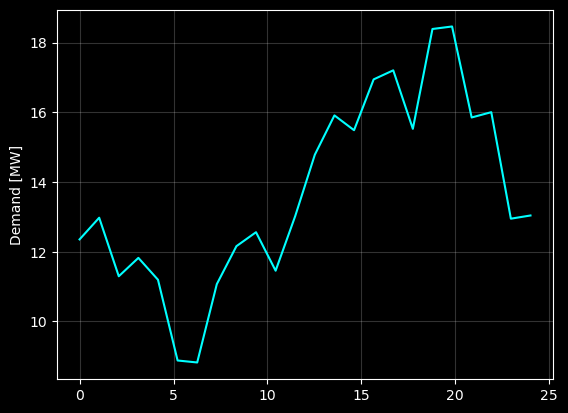

In [14]:
n_hours = 24  # hours per day
n_days = 1  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 328.16  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

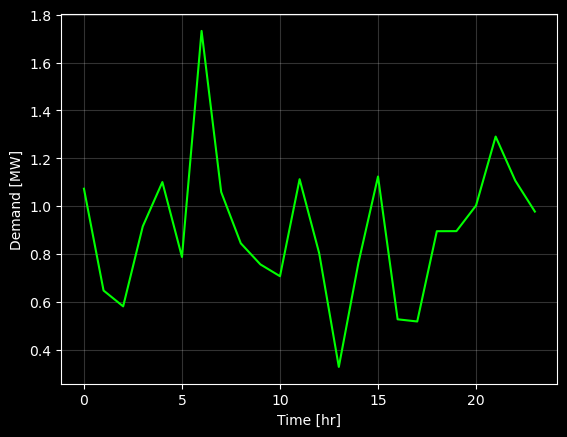

In [15]:
#creating wind profile
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()

In [16]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind,lib.nuclear]
display(UIUC_mix)

[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW,
 Nuclear: 18609.404000000002 MW]

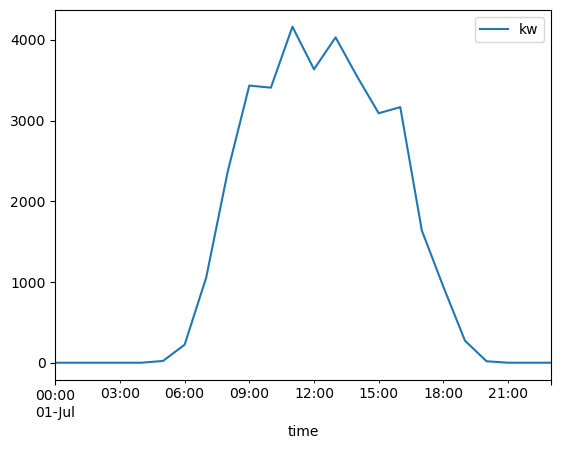

In [17]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()
solar_day_ener = [0,0,0,0,0,22.15,
                  223.25,1052.75,2368.25,3433,3406.75,4161.75,
                  3634.5,4030.25,3545,3090,3165.75,1637.75,
                  940,273.25,18.0475,0,0,0]
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])

In [18]:
solar_ener = df_solar['Energy'].values
solar_ener

array([   0.    ,    0.    ,    0.    ,    0.    ,    0.    ,   22.15  ,
        223.25  , 1052.75  , 2368.25  , 3433.    , 3406.75  , 4161.75  ,
       3634.5   , 4030.25  , 3545.    , 3090.    , 3165.75  , 1637.75  ,
        940.    ,  273.25  ,   18.0475,    0.    ,    0.    ,    0.    ])

In [19]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            wind=wind_speed,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [20]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination=('n_gen', 40),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |      3 |  0.2072994298 |         ideal
     3 |       60 |      7 |  0.0373228047 |         ideal
     4 |       80 |      5 |  0.9621096636 |         ideal
     5 |      100 |      2 |  0.1080890263 |         ideal
     6 |      120 |      5 |  0.2959389723 |         ideal
     7 |      140 |     10 |  0.3513756637 |         ideal
     8 |      160 |      6 |  0.0147456038 |         ideal
     9 |      180 |      6 |  0.1190098124 |         ideal
    10 |      200 |      7 |  0.4531006077 |         ideal
    11 |      220 |     10 |  0.0650943336 |         ideal
    12 |      240 |     12 |  0.2811896803 |         ideal
    13 |      260 |     14 |  0.0612671653 |         ideal
    14 |      280 |     20 |  0.0056690956 |         ideal
    15 |      300 |     20 |  0.0072863900 |         ideal
    16 |      320 |     19 |  0.0434979855 |         ide

In [21]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[1.18617281e+00, 1.46981761e-04],
       [4.36311776e+00, 8.76777851e-06],
       [3.97323430e+00, 8.78899440e-06],
       [3.52711392e+00, 1.04738517e-05],
       [2.17473937e+00, 5.84323788e-05],
       [2.28588230e+00, 3.42487461e-05],
       [1.85677084e+00, 7.88811741e-05],
       [1.26853937e+00, 1.37788592e-04],
       [2.02053178e+00, 7.11318579e-05],
       [2.75352490e+00, 3.07183379e-05],
       [1.69982548e+00, 8.93977661e-05],
       [2.96570192e+00, 1.97557856e-05],
       [1.36591305e+00, 1.24949147e-04],
       [2.35770374e+00, 3.20033742e-05],
       [1.41147520e+00, 1.19333485e-04],
       [2.79254209e+00, 2.42362662e-05],
       [3.19861360e+00, 1.17882819e-05],
       [2.15111758e+00, 6.48753397e-05],
       [1.54460715e+00, 1.08100271e-04],
       [3.11856718e+00, 1.24393693e-05]])

array([[9.03021698e-01, 3.91189617e-02, 1.16378290e-01, 1.79432322e-02,
        5.81769441e-02],
       [7.77828336e-01, 5.35834257e-02, 4.70487485e-01, 2.18748297e+00,
        6.82933909e-03],
       [2.37469168e-01, 6.06614126e-03, 4.81206811e-01, 2.18608976e+00,
        5.82682147e-02],
       [3.10472947e-01, 3.72762695e-02, 4.14511893e-01, 1.88354518e+00,
        3.78628802e-02],
       [7.26023129e-01, 3.79827253e-02, 8.59324388e-01, 4.62993787e-01,
        6.31185573e-02],
       [4.97445587e-01, 1.42312248e-02, 4.81207522e-01, 9.20421790e-01,
        3.97478074e-02],
       [8.03322354e-01, 3.44896449e-02, 7.02775239e-01, 2.13958419e-01,
        8.90242915e-02],
       [9.02542069e-01, 3.91349585e-02, 2.51930930e-01, 1.35700944e-02,
        5.88326509e-02],
       [7.93179576e-01, 4.14675815e-02, 4.62401283e-01, 4.65401366e-01,
        7.25560037e-02],
       [7.93179576e-01, 4.23490284e-02, 4.62401283e-01, 9.42635213e-01,
        8.02421494e-02],
       [8.03322354e-01, 3.4389

(None, None)

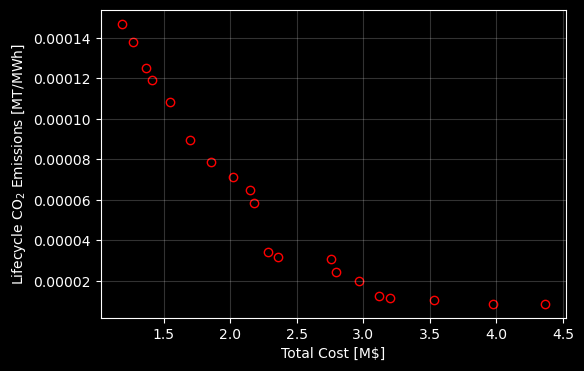

In [22]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()